In [50]:
import pandas as pd
import numpy as np
import numpy.random as nrd

import matplotlib.pyplot as plt

from SOM import SelfOrganizingMaps
from sklearn.cluster import KMeans

# Exercise 14.6

Write programs to implement K-means clustering and a selforganizing map (SOM), with the prototype lying on a two-dimensional
grid. Apply them to the columns of the human tumor microarray data, using K = 2, 5, 10, 20 centroids for both. Demonstrate that as the size of the
SOM neighborhood is taken to be smaller and smaller, the SOM solution
becomes more similar to the K-means solution.

# Solution

Let's load the data first,

In [13]:
url_link = 'https://web.stanford.edu/~hastie/ElemStatLearn/datasets/nci.data.csv'
df = pd.read_csv(url_link,index_col=0)

df.tail()

,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,...,s55,s56,s57,s58,s59,s60,s61,s62,s63,s64
g6826,-0.03,-0.860039,-0.15,-0.30000,0.605,-0.40000,0.47000,-0.09000,-0.33000,-0.33000,...,-0.16,0.31000,-0.84,0.219980,0.22,-0.02000,-0.16000,0.39,-0.35000,0.48000
g6827,0.00,-1.250049,0.00,-1.15001,0.000,0.69999,0.12999,-0.70001,-0.60001,-1.22001,...,0.00,-1.33001,0.00,-1.100029,0.00,-1.39001,-0.02001,0.00,-0.36001,0.96999
g6828,0.28,-0.770039,-0.12,1.09000,0.745,0.29000,-0.30000,-0.54000,0.83000,-0.17000,...,0.15,-1.21000,-0.58,-0.520019,-0.87,-1.15000,-0.64000,0.16,-0.49000,0.29000
g6829,-0.34,-0.390039,-0.41,-0.26000,0.425,0.55000,0.57000,-0.45000,-0.03000,-0.11000,...,-0.53,0.30000,-0.47,-0.550019,-0.33,0.29000,-0.37000,2.03,0.01000,-0.15000
g6830,-1.93,-2.000039,0.00,-1.10000,0.145,0.00000,0.00000,-2.09000,0.65000,-1.79000,...,0.00,1.37000,0.00,-1.560020,-0.61,1.19000,-0.43000,3.94,-1.72000,1.21000


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6830 entries, g1 to g6830
Data columns (total 64 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   s1      6830 non-null   float64
 1   s2      6830 non-null   float64
 2   s3      6830 non-null   float64
 3   s4      6830 non-null   float64
 4   s5      6830 non-null   float64
 5   s6      6830 non-null   float64
 6   s7      6830 non-null   float64
 7   s8      6830 non-null   float64
 8   s9      6830 non-null   float64
 9   s10     6830 non-null   float64
 10  s11     6830 non-null   float64
 11  s12     6830 non-null   float64
 12  s13     6830 non-null   float64
 13  s14     6830 non-null   float64
 14  s15     6830 non-null   float64
 15  s16     6830 non-null   float64
 16  s17     6830 non-null   float64
 17  s18     6830 non-null   float64
 18  s19     6830 non-null   float64
 19  s20     6830 non-null   float64
 20  s21     6830 non-null   float64
 21  s22     6830 non-null   float64
 22  s23

Now we get the input matrix and the response vector (not needed for SOM or K-Means, but useful to see how the genes are clustered)

In [26]:
# Input matrix
X = df.to_numpy().T
N,p = X.shape

# response vector
url_label = 'https://web.stanford.edu/~hastie/ElemStatLearn/datasets/nci.label.txt'
y = np.loadtxt(url_label,dtype=str)

## Clustering the tumors

We apply SOM and K-means to the columns of the dataset, using different values of K to cluster them. First, let's introduce a few functions that come handy later,

In [77]:
# Compute the reconstruction error for the model
def reconstruction_error_Kmeans(X,centroids):

    N,_ = X.shape

    # Compute distance of each observation from the prototypes
    distances = np.empty((N,0))
    for m in centroids:
        dist_m = np.sum((X-m)**2,axis=1)
        distances = np.hstack((distances,dist_m.reshape((N,1))))

    # Sum the minimum distance for each observation
    error = np.sum(np.min(distances,axis=1))

    return error

# Plot the clusters given by SOM
def plot_clusters(cluster_SOM,y,eps=3e-1):
    
    size, cluster = cluster_SOM
    n,m = size

    class_types = set(y)

    for cls in class_types:
        x_coord = np.empty(0)
        y_coord = np.empty(0)
        for i in range(n):
            for j in range(m):
                # Compute how many observation of that class belong to the cluster
                n_points = np.sum(cluster[(i,j)]==cls)

                x_coord = np.concatenate((x_coord,np.full(n_points,i)+eps*nrd.rand(n_points)))
                y_coord = np.concatenate((y_coord,np.full(n_points,j)+eps*nrd.rand(n_points)))

        plt.scatter(x_coord,y_coord,label=cls)

    plt.title('Final clustering for {}x{} grid'.format(n,m))
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()

We can now apply the algorithms for a different number of prototypes, and plot the reconstruction error,

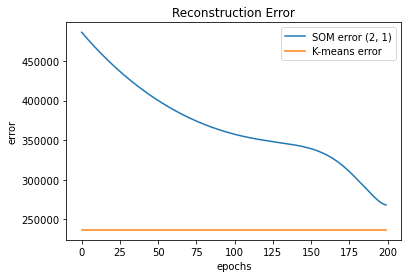

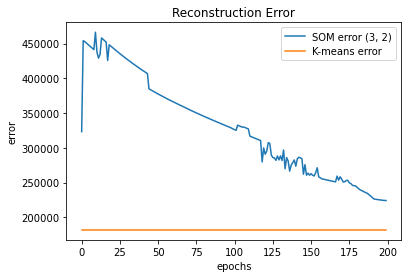

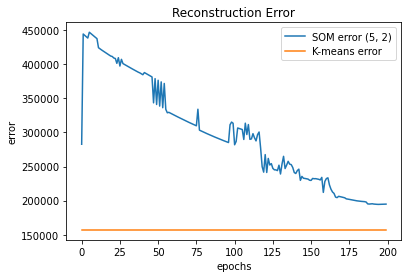

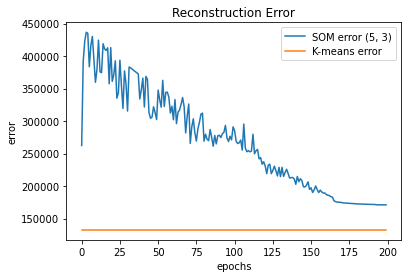

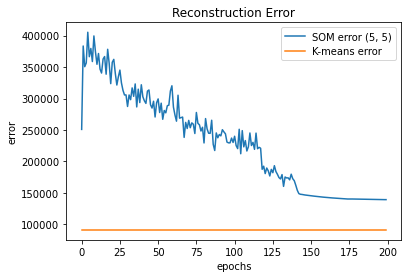

In [39]:
# Number of prototypes per direction
grid_sizes = [(2,1),(3,2),(5,2),(5,3),(5,5)]

# Number of iterations for the training
epochs = 200
iterations = epochs*N

# Parameter of the model
alpha = 1.
r = 2.

clusters_SOM = []
clusters_KM = []

for grid_size in grid_sizes:
    
    # SOM model and its reconstruction error
    model = SelfOrganizingMaps(grid_size)
    model.fit(X,iterations,alpha,r)
    SOM_error = model.learning_curve
    
    # K-means model and its reconstruction error
    K = np.prod(grid_size)
    kmeans = KMeans(n_clusters=K)
    kmeans.fit(X)
    centroids = kmeans.cluster_centers_
    Kmeans_error = reconstruction_error_Kmeans(X,centroids)
    
    # Additionally, store the clustering produced by SOM and K-Means
    clusters_SOM.append((grid_size,model.cluster(X,y)))
    clusters_KM.append(kmeans.predict(X))
    
    # Plot the reconstruction error for the two methods
    plt.plot(SOM_error,label='SOM error {}'.format(grid_size))
    plt.plot([Kmeans_error]*epochs,label='K-means error (K={})'.format(K))
    plt.title('Reconstruction Error')
    plt.xlabel('epochs')
    plt.ylabel('error')
    plt.legend()
    plt.show()

Let's visualize the different clustering provided by SOM (for different grids),

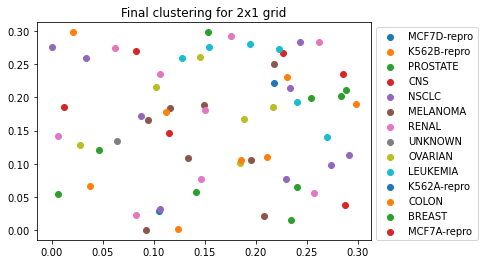

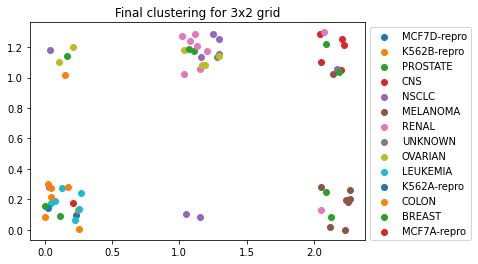

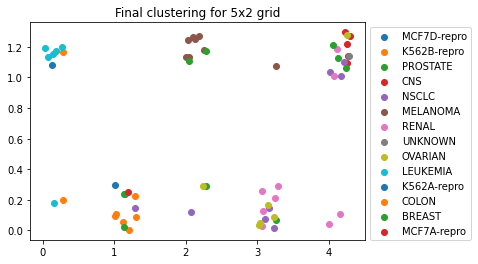

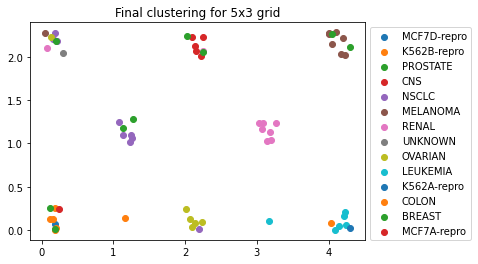

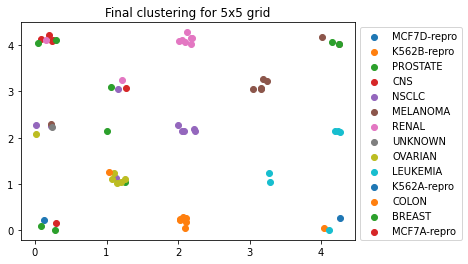

In [78]:
for cluster in clusters_SOM:
    plot_clusters(cluster,y)

# Convergence of SOM to K-Means

To conclude the exercise, it is suggested to set r = 1 and check that SOM behaves as K-means. Let's see,

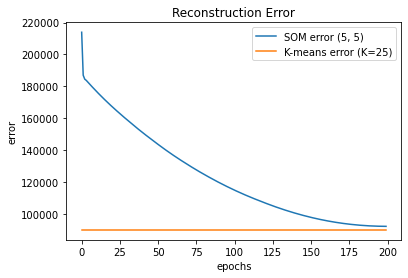

In [80]:
# Number of prototypes per direction
grid_size = (5,5)
K = 25

# Number of iterations for the training
epochs = 200
iterations = epochs*N

# Parameter of the model
alpha = 1.
r = 1.

# SOM model
model = SelfOrganizingMaps(grid_size)
model.fit(X,iterations,alpha,r)
SOM_error = model.learning_curve

# K-Means model
kmeans = KMeans(n_clusters=K)
kmeans.fit(X)
centroids = kmeans.cluster_centers_
Kmeans_error = reconstruction_error_Kmeans(X,centroids)

# Plot the reconstruction error for the two methods
plt.plot(SOM_error,label='SOM error {}'.format(grid_size))
plt.plot([Kmeans_error]*epochs,label='K-means error (K={})'.format(K))
plt.title('Reconstruction Error')
plt.xlabel('epochs')
plt.ylabel('error')
plt.legend()
plt.show()